## Post processing:
* Global Signal Regression using orthogonalization
* Band Pass filtering 0.1 - 0.01 Hz
* Motion regression using GLM



In [60]:
from bids.grabbids import BIDSLayout
from nipype.interfaces.fsl import (BET, ExtractROI, FAST, FLIRT, ImageMaths,
                                   MCFLIRT, SliceTimer, Threshold,Info, ConvertXFM,MotionOutliers)
from nipype.interfaces.afni import Resample
from nipype.interfaces.io import DataSink
from nipype.pipeline import Node, MapNode, Workflow, JoinNode
from nipype.interfaces.utility import IdentityInterface, Function
import os
from os.path import join as opj
from nipype.interfaces import afni
import nibabel as nib
import json    
import numpy as np

In [61]:
# Paths
os.chdir('/home1/varunk/Autism-Connectome-Analysis-brain_connectivity/notebooks/')
path_cwd = os.getcwd()
path_split_list = path_cwd.split('/')
s = path_split_list[0:-2] # for getting to the parent dir of pwd
s = opj('/',*s) # *s converts list to path, # very important to add '/' in the begining so it is read as directory later



In [62]:

# json_path = opj(data_directory,'task-rest_bold.json')

json_path = '../scripts/json/paths.json'
with open(json_path, 'rt') as fp:
    task_info = json.load(fp)
    

In [63]:
# base_directory = opj(s,'result') 
# parent_wf_directory = 'preprocessPipeline_ABIDE2_GU1_withfloat'
# child_wf_directory = 'coregistrationPipeline'

# data_directory = opj(s,"data/ABIDE2-BIDS/GU1")

# datasink_name = 'datasink_preprocessed_ABIDE2_GU1_withfloat'

base_directory = opj(s,task_info["base_directory_for_results"]) 
motion_correction_bet_directory = task_info["motion_correction_bet_directory"]
parent_wf_directory = task_info["parent_wf_directory"]
# functional_connectivity_directory = task_info["functional_connectivity_directory"]
functional_connectivity_directory = 'temp_fc'
coreg_reg_directory = task_info["coreg_reg_directory"]
atlas_resize_reg_directory = task_info["atlas_resize_reg_directory"]
data_directory = opj(s,task_info["data_directory"])
datasink_name = task_info["datasink_name"]
# fc_datasink_name = task_info["fc_datasink_name"]
fc_datasink_name = 'temp_dataSink'
atlasPath = opj(s,task_info["atlas_path"])


# mask_file = '/media/varun/LENOVO4/Projects/result/preprocessPipeline/coregistrationPipeline/_subject_id_0050952/skullStrip/sub-0050952_T1w_resample_brain_mask.nii.gz'
# os.chdir(path)

In [64]:
# opj(base_directory,parent_wf_directory,motion_correction_bet_directory,coreg_reg_directory,'resample_mni')

In [65]:
brain_path = opj(base_directory,datasink_name,'preprocessed_brain_paths/brain_file_list.npy')
mask_path = opj(base_directory,datasink_name,'preprocessed_mask_paths/mask_file_list.npy')
atlas_path = opj(base_directory,datasink_name,'atlas_paths/atlas_file_list.npy')
tr_path = opj(base_directory,datasink_name,'tr_paths/tr_list.npy')
motion_params_path = opj(base_directory,datasink_name,'motion_params_paths/motion_params_file_list.npy')

func2std_mat_path = opj(base_directory, datasink_name,'joint_xformation_matrix_paths/joint_xformation_matrix_file_list.npy')

MNI3mm_path = opj(base_directory,parent_wf_directory,motion_correction_bet_directory,coreg_reg_directory,'resample_mni/MNI152_T1_2mm_brain_resample.nii') 

# brain_list = np.load('../results_again_again/ABIDE1_Preprocess_Datasink/preprocessed_brain_paths/brain_file_list.npy')

In [66]:
# brain_path,mask_path,atlas_path,tr_path,motion_params_path,func2std_mat_path

In [67]:
brain_path = np.load(brain_path)
mask_path = np.load(mask_path)
atlas_path = np.load(atlas_path)
tr_path = np.load(tr_path)
motion_params_path = np.load(motion_params_path)
func2std_mat_path = np.load(func2std_mat_path)

In [68]:
# for a,b,c,d,e in zip(brain_path,mask_path,atlas_path,tr_path,motion_params_path):
#     print (a,b,c,d,e,'\n')

## Read the smoothed files
* The following files are filtered and smoothed motion parameter regressed
I got the file name using the command:  
```
find . -name "sub-*_task-rest_run-1_bold_roi_st_mcf_residual_bp_smoothed.nii.gz" > smoothed_brains.txt
```
* Using the above extracted filenames to do the following:
    * Select the subjects having volumes atlest the required fixed number of volumes
    * perform correlation using just the fixed number of volumes
    * Register the file to the standard 3mm template


In [97]:
smoothed_brains_in_file = '/home1/varunk/results_again_again/smoothed_brains.txt'
import re


smoothed_brains_paths = np.loadtxt(smoothed_brains_in_file, dtype = np.str)

smoothed_brains_subid = []
for path in smoothed_brains_paths:
    sub_id_extracted = re.search('.+_subject_id_(\d+)', path).group(1)
    print(sub_id_extracted)
    smoothed_brains_subid.append(int(sub_id_extracted))



0050977
0051151
0051171
0050275
0050366
0051335
0050311
0050529
0050291
0051082
0051564
0051009
0051060
0050485
0051088
0050243
0050722
0051194
0050287
0050628
0051020
0051359
0050351
0050496
0050408
0050779
0051064
0051167
0051234
0050260
0050388
0051327
0051190
0051346
0050524
0050043
0051059
0050206
0050153
0050464
0050447
0050683
0050417
0050621
0051046
0051252
0051208
0050427
0050147
0050645
0051057
0051240
0050165
0051229
0051585
0051085
0050189
0050663
0051122
0050440
0050208
0050789
0050558
0051024
0050383
0051010
0050689
0050405
0050749
0050201
0050449
0051304
0051469
0050578
0051292
0050574
0051040
0050037
0051028
0050160
0050375
0050476
0051019
0050261
0051250
0051131
0050353
0050316
0051329
0050407
0050488
0051323
0050980
0051349
0051471
0050055
0050782
0051330
0051075
0050810
0051325
0051300
0051568
0051366
0051149
0050203
0050300
0050335
0050532
0050990
0051134
0051114
0050688
0051015
0050116
0050028
0050411
0051179
0051215
0051491
0051350
0050146
0050105
0050708
0050704


In [98]:
smoothed_brains_paths

array([ './_subject_id_0050977/spatialSmooth/sub-0050977_task-rest_run-1_bold_roi_st_mcf_residual_bp_smoothed.nii.gz',
       './_subject_id_0051151/spatialSmooth/sub-0051151_task-rest_run-1_bold_roi_st_mcf_residual_bp_smoothed.nii.gz',
       './_subject_id_0051171/spatialSmooth/sub-0051171_task-rest_run-1_bold_roi_st_mcf_residual_bp_smoothed.nii.gz',
       ...,
       './_subject_id_0050802/spatialSmooth/sub-0050802_task-rest_run-1_bold_roi_st_mcf_residual_bp_smoothed.nii.gz',
       './_subject_id_0050791/spatialSmooth/sub-0050791_task-rest_run-1_bold_roi_st_mcf_residual_bp_smoothed.nii.gz',
       './_subject_id_0051212/spatialSmooth/sub-0051212_task-rest_run-1_bold_roi_st_mcf_residual_bp_smoothed.nii.gz'],
      dtype='<U107')

In [99]:
base_directory

'/home1/varunk/results_again_again'

In [100]:
smoothed_brains_subid

[50977,
 51151,
 51171,
 50275,
 50366,
 51335,
 50311,
 50529,
 50291,
 51082,
 51564,
 51009,
 51060,
 50485,
 51088,
 50243,
 50722,
 51194,
 50287,
 50628,
 51020,
 51359,
 50351,
 50496,
 50408,
 50779,
 51064,
 51167,
 51234,
 50260,
 50388,
 51327,
 51190,
 51346,
 50524,
 50043,
 51059,
 50206,
 50153,
 50464,
 50447,
 50683,
 50417,
 50621,
 51046,
 51252,
 51208,
 50427,
 50147,
 50645,
 51057,
 51240,
 50165,
 51229,
 51585,
 51085,
 50189,
 50663,
 51122,
 50440,
 50208,
 50789,
 50558,
 51024,
 50383,
 51010,
 50689,
 50405,
 50749,
 50201,
 50449,
 51304,
 51469,
 50578,
 51292,
 50574,
 51040,
 50037,
 51028,
 50160,
 50375,
 50476,
 51019,
 50261,
 51250,
 51131,
 50353,
 50316,
 51329,
 50407,
 50488,
 51323,
 50980,
 51349,
 51471,
 50055,
 50782,
 51330,
 51075,
 50810,
 51325,
 51300,
 51568,
 51366,
 51149,
 50203,
 50300,
 50335,
 50532,
 50990,
 51134,
 51114,
 50688,
 51015,
 50116,
 50028,
 50411,
 51179,
 51215,
 51491,
 51350,
 50146,
 50105,
 50708,
 50704,


In [101]:
# Append the conplete brain path to smoothed brain paths
new_brain_paths = []
for path in smoothed_brains_paths:
    new_brain_paths.append(opj(base_directory, 'motionRegress1filt1global0smoothing1',path[2:]))

In [102]:
new_brain_paths

['/home1/varunk/results_again_again/motionRegress1filt1global0smoothing1/_subject_id_0050977/spatialSmooth/sub-0050977_task-rest_run-1_bold_roi_st_mcf_residual_bp_smoothed.nii.gz',
 '/home1/varunk/results_again_again/motionRegress1filt1global0smoothing1/_subject_id_0051151/spatialSmooth/sub-0051151_task-rest_run-1_bold_roi_st_mcf_residual_bp_smoothed.nii.gz',
 '/home1/varunk/results_again_again/motionRegress1filt1global0smoothing1/_subject_id_0051171/spatialSmooth/sub-0051171_task-rest_run-1_bold_roi_st_mcf_residual_bp_smoothed.nii.gz',
 '/home1/varunk/results_again_again/motionRegress1filt1global0smoothing1/_subject_id_0050275/spatialSmooth/sub-0050275_task-rest_run-1_bold_roi_st_mcf_residual_bp_smoothed.nii.gz',
 '/home1/varunk/results_again_again/motionRegress1filt1global0smoothing1/_subject_id_0050366/spatialSmooth/sub-0050366_task-rest_run-1_bold_roi_st_mcf_residual_bp_smoothed.nii.gz',
 '/home1/varunk/results_again_again/motionRegress1filt1global0smoothing1/_subject_id_0051335/sp

## Check which subjects have volumes > 'vol'

In [103]:
import pandas as pd

demographics_file_path = '/home1/varunk/Autism-Connectome-Analysis-brain_connectivity/notebooks/demographics.csv'
phenotype_file_path = '/home1/varunk/data/ABIDE1/RawDataBIDs/composite_phenotypic_file.csv'

df_phenotype = pd.read_csv(phenotype_file_path)
df_phenotype = df_phenotype.sort_values(['SUB_ID'])
df_phenotype_sub_id = df_phenotype.as_matrix(['SITE_ID','SUB_ID']).squeeze()

df_demographics = pd.read_csv(demographics_file_path)
df_demographics_volumes = df_demographics.as_matrix(['SITE_NAME','VOLUMES']).squeeze()


In [104]:
# df_phenotype.sort_values(['SUB_ID'])

In [105]:
df_demographics_volumes

array([['CALTECH', 150.0],
       ['CMU', 240.0],
       ['KKI', 156.0],
       ['LEUVEN_1', 250.0],
       ['LEUVEN_2', 250.0],
       ['MAX_MUN', 120.0],
       ['NYU', 180.0],
       ['OHSU', 82.0],
       ['OLIN', 210.0],
       ['PITT', 200.0],
       ['SBL', 200.0],
       ['SDSU', 180.0],
       ['STANFORD', 180.0],
       ['TRINITY', 150.0],
       ['UCLA_1', 120.0],
       ['UCLA_2', 120.0],
       ['UM_1', 300.0],
       ['UM_2', 300.0],
       ['USM', 240.0],
       ['YALE', 200.0]], dtype=object)

In [106]:
# SUB_ID - Volumes Dictionary
site_vol_dict = dict(zip(df_demographics_volumes[:,0], df_demographics_volumes[:,1]))

# for site_subid in df_demographics_volumes:
    

# subid_site_dict = dict(zip(df_phenotype_sub_id[:,1], df_phenotype_sub_id[:,0]))

In [107]:
subid_vol_dict = dict(zip(df_phenotype_sub_id[:,1],[site_vol_dict[site] for site in df_phenotype_sub_id[:,0]] ))

In [108]:
(subid_vol_dict)

{50002: 200.0,
 50003: 200.0,
 50004: 200.0,
 50005: 200.0,
 50006: 200.0,
 50007: 200.0,
 50008: 200.0,
 50009: 200.0,
 50010: 200.0,
 50011: 200.0,
 50012: 200.0,
 50013: 200.0,
 50014: 200.0,
 50015: 200.0,
 50016: 200.0,
 50017: 200.0,
 50019: 200.0,
 50020: 200.0,
 50022: 200.0,
 50023: 200.0,
 50024: 200.0,
 50025: 200.0,
 50026: 200.0,
 50027: 200.0,
 50028: 200.0,
 50029: 200.0,
 50030: 200.0,
 50031: 200.0,
 50032: 200.0,
 50033: 200.0,
 50034: 200.0,
 50035: 200.0,
 50036: 200.0,
 50037: 200.0,
 50038: 200.0,
 50039: 200.0,
 50040: 200.0,
 50041: 200.0,
 50042: 200.0,
 50043: 200.0,
 50044: 200.0,
 50045: 200.0,
 50046: 200.0,
 50047: 200.0,
 50048: 200.0,
 50049: 200.0,
 50050: 200.0,
 50051: 200.0,
 50052: 200.0,
 50053: 200.0,
 50054: 200.0,
 50055: 200.0,
 50056: 200.0,
 50057: 200.0,
 50058: 200.0,
 50059: 200.0,
 50060: 200.0,
 50102: 210.0,
 50103: 210.0,
 50104: 210.0,
 50105: 210.0,
 50106: 210.0,
 50107: 210.0,
 50108: 210.0,
 50109: 210.0,
 50110: 210.0,
 50111: 21

In [109]:
vols = 120
del_idx = []
for idx,df in enumerate(df_demographics_volumes):
#     print(idx,df[1])
    if df[1] < vols:
        del_idx.append(idx)
        
df_demographics_volumes = np.delete(df_demographics_volumes,del_idx, axis = 0)

In [110]:
df_demographics_sites_refined = df_demographics_volumes[:,0]

In [111]:
df_demographics_sites_refined

array(['CALTECH', 'CMU', 'KKI', 'LEUVEN_1', 'LEUVEN_2', 'MAX_MUN', 'NYU',
       'OLIN', 'PITT', 'SBL', 'SDSU', 'STANFORD', 'TRINITY', 'UCLA_1',
       'UCLA_2', 'UM_1', 'UM_2', 'USM', 'YALE'], dtype=object)

In [112]:
df_phenotype_sub_id

array([['PITT', 50002],
       ['PITT', 50003],
       ['PITT', 50004],
       ..., 
       ['SBL', 51585],
       ['MAX_MUN', 51606],
       ['MAX_MUN', 51607]], dtype=object)

### Subject IDs to be considered - 
```subjects_refined```

In [117]:
subjects_refined = []
for df in df_phenotype_sub_id:
    if df[0] in df_demographics_sites_refined:
#         print(df[1])
        subjects_refined.append(df[1])

In [118]:
subjects_refined;

In [130]:
subjects_refined = list(set(subjects_refined) - (set(df_phenotype_sub_id[:,1]) - set(smoothed_brains_subid) ) )

In [131]:
len(subjects_refined)

1074

#### Below are subject IDs to be ignored

In [26]:
#sanity check
set(df_phenotype_sub_id[:,1]) - set(subjects_refined)

{50142,
 50143,
 50144,
 50145,
 50146,
 50147,
 50148,
 50149,
 50150,
 50152,
 50153,
 50155,
 50156,
 50157,
 50158,
 50159,
 50160,
 50161,
 50162,
 50163,
 50164,
 50165,
 50166,
 50167,
 50168,
 50169,
 50170,
 50171}

## Volume correction
* I have already extracted 4 volumes.
* Now extract 120 - 4 = 116 volumes from each subject
* So define vols = 114


In [27]:
vols = vols - 4

In [28]:
def vol_correct(sub_id, subid_vol_dict, vols):
    sub_vols = subid_vol_dict[sub_id] - 4
    if sub_vols > vols:
        t_min = sub_vols - vols
    elif sub_vols == vols:
        t_min = 0
    else:
        raise Exception('Volumes of Sub ',sub_id,' less than desired!')
    return int(t_min)

In [29]:

volCorrect = Node(Function(function=vol_correct, input_names=['sub_id','subid_vol_dict','vols'],
                                output_names=['t_min']), name='volCorrect')

volCorrect.inputs.subid_vol_dict = subid_vol_dict
volCorrect.inputs.vols = vols

In [30]:
os.chdir('/home1/varunk/results_again_again/temp/')
volCorrect.inputs.sub_id = 51456
res = volCorrect.run()

171229-15:24:16,511 workflow INFO:
	 Executing node volCorrect in dir: /tmp/tmpf64ev894/volCorrect


In [31]:
res.outputs


t_min = 30

In [32]:
# 146 - 116

# 0...145

# 145 - 30 + 1

In [33]:
# 146 - 116

In [34]:
# fslroi /home1/varunk/results_again_again/motionRegress1filt1global0smoothing1/_subject_id_0051456/spatialSmooth/sub-0051456_task-rest_run-1_bold_roi_st_mcf_residual_bp_smoothed.nii.gz /home1/varunk/results_again_again/temp_fc/motionRegress1filt1global0smoothing1/_subject_id_51456/extract/sub-0051456_task-rest_run-1_bold_roi_st_mcf_residual_bp_smoothed_roi.nii.gz 35 -1

In [35]:

# # ExtractROI - skip dummy scans
# extract = Node(ExtractROI(t_size=-1),
#                output_type='NIFTI',
#                name="extract")

# # t_min=4,

In [36]:
# layout = BIDSLayout(data_directory)

number_of_subjects = 2 # Number of subjects you wish to preprocess
# number_of_subjects = len(layout.get_subjects())

## Define a function to fetch the filenames of a particular subject ID

In [37]:
def get_subject_filenames_old(subject_id,brain_path,mask_path,atlas_path,tr_path,motion_params_path,func2std_mat_path,MNI3mm_path):
    import re

    for brain,mask,atlas,tr,motion_param,func2std_mat in zip(brain_path,mask_path,atlas_path,tr_path,motion_params_path,func2std_mat_path):
        sub_id_extracted = re.search('.+_subject_id_(\d+)', brain)
        
        if str(subject_id) in brain:
#             print("Files for subject ",subject_id,brain,mask,atlas,tr,motion_param)
            return brain,mask,atlas,tr,motion_param,func2std_mat,MNI3mm_path
        
    print ('Unable to locate Subject: ',subject_id,'extracted: ',sub_id_extracted)
    return 0
    

In [53]:
def get_subject_filenames(subject_id,brain_path,mask_path,atlas_path,tr_path,motion_params_path,func2std_mat_path,MNI3mm_path):
    import re

    for brain in brain_path:
        sub_id_extracted = re.search('.+_subject_id_(\d+)', brain)
        print(sub_id_extracted)
        
        if str(subject_id) in brain:
            for mask,atlas,tr,motion_param,func2std_mat in zip(mask_path,atlas_path,tr_path,motion_params_path,func2std_mat_path):
                if str(subject_id) in mask:
        #             print("Files for subject ",subject_id,brain,mask,atlas,tr,motion_param)
                    return brain,mask,atlas,tr,motion_param,func2std_mat,MNI3mm_path
        
    print ('Unable to locate Subject: ',subject_id,'extracted: ',sub_id_extracted)
    raise Exception('Unable to locate Subject: ',subject_id,'extracted: ',sub_id_extracted)
    return 0
    

In [58]:
# 555/60 # mask_path,new_brain_paths

9.25

In [55]:
len(new_brain_paths),len(mask_path), len(subjects_refined)

(1102, 1102, 1084)

In [56]:
# Make a node
getSubjectFilenames = Node(Function(function=get_subject_filenames, input_names=['subject_id','brain_path','mask_path','atlas_path','tr_path','motion_params_path','func2std_mat_path','MNI3mm_path'],
                                output_names=['brain','mask','atlas','tr','motion_param','func2std_mat', 'MNI3mm_path']), name='getSubjectFilenames')


# getSubjectFilenames.inputs.brain_path = brain_path
getSubjectFilenames.inputs.brain_path = new_brain_paths
getSubjectFilenames.inputs.mask_path = mask_path
getSubjectFilenames.inputs.atlas_path = atlas_path
getSubjectFilenames.inputs.tr_path = tr_path
getSubjectFilenames.inputs.motion_params_path = motion_params_path
getSubjectFilenames.inputs.func2std_mat_path = func2std_mat_path
getSubjectFilenames.inputs.MNI3mm_path = MNI3mm_path

In [57]:
getSubjectFilenames.inputs.subject_id = 51270
res = getSubjectFilenames.run()

171229-15:39:39,400 workflow INFO:
	 Executing node getSubjectFilenames in dir: /tmp/tmp0tw34ts6/getSubjectFilenames
<_sre.SRE_Match object; span=(0, 90), match='/home1/varunk/results_again_again/motionRegress1f>
<_sre.SRE_Match object; span=(0, 90), match='/home1/varunk/results_again_again/motionRegress1f>
<_sre.SRE_Match object; span=(0, 90), match='/home1/varunk/results_again_again/motionRegress1f>
<_sre.SRE_Match object; span=(0, 90), match='/home1/varunk/results_again_again/motionRegress1f>
<_sre.SRE_Match object; span=(0, 90), match='/home1/varunk/results_again_again/motionRegress1f>
<_sre.SRE_Match object; span=(0, 90), match='/home1/varunk/results_again_again/motionRegress1f>
<_sre.SRE_Match object; span=(0, 90), match='/home1/varunk/results_again_again/motionRegress1f>
<_sre.SRE_Match object; span=(0, 90), match='/home1/varunk/results_again_again/motionRegress1f>
<_sre.SRE_Match object; span=(0, 90), match='/home1/varunk/results_again_again/motionRegress1f>
<_sre.SRE_Match obj

Exception: ('Unable to locate Subject: ', 51270, 'extracted: ', <_sre.SRE_Match object; span=(0, 90), match='/home1/varunk/results_again_again/motionRegress1f>, '\nInterface Function failed to run.')

In [1544]:
# import re
# text = '/home1/varunk/results_again_again/ABIDE1_Preprocess/motion_correction_bet/coreg_reg/atlas_resize_reg_directory/_subject_id_0050004/111std2func_xform/fullbrain_atlas_thr0-2mm_resample_flirt.nii'

# try:
#     found = re.search('.+_subject_id_(\d+)', text).group(1)
# except AttributeError:
#     # AAA, ZZZ not found in the original string
#     found = '' # apply your error handling

# # found: 1234


In [1545]:
# found

In [1546]:
subject_list = subjects_refined[0:number_of_subjects]

In [1547]:
infosource = Node(IdentityInterface(fields=['subject_id']),
                  name="infosource")

infosource.iterables = [('subject_id',subject_list)]


# ,'brain_path','mask_path','atlas_path','tr_path','motion_params_path'
# infosource.brain_path = brain_path
# infosource.mask_path = mask_path
# infosource.atlas_path = atlas_path
# infosource.tr_path = tr_path
# infosource.motion_params_path = motion_params_path

## Extract volumes

In [1548]:
# ExtractROI - skip dummy scans
extract = Node(ExtractROI(t_size=-1),
               output_type='NIFTI',
               name="extract")

# t_min=4,

## Datasink
I needed to define the structure of what files are saved and where.

In [1549]:
# Create DataSink object
dataSink = Node(DataSink(), name='datasink')

# Name of the output folder
dataSink.inputs.base_directory = opj(base_directory,fc_datasink_name)


To create the substitutions I looked the `datasink` folder where I was redirecting the output. I manually selected the part of file/folder name that I wanted to change and copied below to be substituted.  


In [1550]:
# Define substitution strings so that the data is similar to BIDS
substitutions = [('_subject_id_', 'sub-')]

# Feed the substitution strings to the DataSink node
dataSink.inputs.substitutions = substitutions

# ('_resample_brain_flirt.nii_brain', ''),
# ('_roi_st_mcf_flirt.nii_brain_flirt', ''),
                

In [1551]:
base_directory

'/home1/varunk/results_again_again'

### Following is a Join Node that collects the preprocessed file paths and saves them in a file

In [1552]:
def save_file_list_function(in_fc_map_brain_file):
    # Imports
    import numpy as np
    import os
    from os.path import join as opj
    
    
    file_list = np.asarray(in_fc_map_brain_file)
    print('######################## File List ######################: \n',file_list)

    np.save('fc_map_brain_file_list',file_list)
    file_name = 'fc_map_brain_file_list.npy'
    out_fc_map_brain_file = opj(os.getcwd(),file_name) # path

    
    
    
    
    
    return out_fc_map_brain_file
    

In [1553]:
save_file_list = JoinNode(Function(function=save_file_list_function, input_names=['in_fc_map_brain_file'],
                 output_names=['out_fc_map_brain_file']),
                 joinsource="infosource",
                 joinfield=['in_fc_map_brain_file'],
                 name="save_file_list")

## Create a FC node

This node:
1. Exracts the average time series of the brain ROI's using the atlas and stores 
    it as a matrix of size [ROIs x Volumes].
2. Extracts the Voxel time series and stores it in matrix of size [Voxels x Volumes]


## Saving the Brains instead of FC matrices

In [1554]:
# Saves the brains instead of FC matrix files
def pear_coff(in_file, atlas_file, mask_file):
    # code to find how many voxels are in the brain region using the mask
    
        # imports
    import numpy as np
    import nibabel as nib
    import os
    from os.path import join as opj

    mask_data = nib.load(mask_file)
    mask = mask_data.get_data()

    x_dim, y_dim, z_dim = mask_data.shape

                    
    atlasPath = atlas_file
    # Read the atlas
    atlasObject = nib.load(atlasPath)
    atlas = atlasObject.get_data()
    
    num_ROIs = int((np.max(atlas) - np.min(atlas) ))


    # Read the brain in_file

    brain_data = nib.load(in_file)
    brain = brain_data.get_data()

    x_dim, y_dim, z_dim, num_volumes = brain.shape
    
    
    num_brain_voxels = 0

    x_dim, y_dim, z_dim = mask_data.shape

    for i in range(x_dim):
        for j in range(y_dim):
            for k in range(z_dim):
                if mask[i,j,k] == 1:
                    num_brain_voxels = num_brain_voxels + 1
    
    # Initialize a matrix of ROI time series and voxel time series

    ROI_matrix = np.zeros((num_ROIs, num_volumes))
    voxel_matrix = np.zeros((num_brain_voxels, num_volumes))
    
    # Fill up the voxel_matrix 

    voxel_counter = 0
    for i in range(x_dim):
        for j in range(y_dim):
            for k in range(z_dim):
                if mask[i,j,k] == 1:
                    voxel_matrix[voxel_counter,:] = brain[i,j,k,:] 
                    voxel_counter = voxel_counter + 1

                    
    # Fill up the ROI_matrix
    # Keep track of number of voxels per ROI as well by using an array - num_voxels_in_ROI[]

    num_voxels_in_ROI = np.zeros((num_ROIs,1)) # A column arrray containing number of voxels in each ROI

    for i in range(x_dim):
        for j in range(y_dim):
            for k in range(z_dim):
                label = int(atlas[i,j,k]) - 1
                if label != -1:
                    ROI_matrix[label,:] = np.add(ROI_matrix[label,:], brain[i,j,k,:])
                    num_voxels_in_ROI[label,0] = num_voxels_in_ROI[label,0] + 1

    ROI_matrix = np.divide(ROI_matrix,num_voxels_in_ROI) # I get nan coz of this! At places where num voxels = 0

    X, Y = ROI_matrix, voxel_matrix


    # Subtract mean from X and Y

    X = np.subtract(X, np.mean(X, axis=1, keepdims=True))
    Y = np.subtract(Y, np.mean(Y, axis=1, keepdims=True))

    temp1 = np.dot(X,Y.T)
    temp2 = np.sqrt(np.sum(np.multiply(X,X), axis=1, keepdims=True))
    temp3 = np.sqrt(np.sum(np.multiply(Y,Y), axis=1, keepdims=True))
    temp4 = np.dot(temp2,temp3.T)
    coff_matrix = np.divide(temp1, (temp4 + 1e-7))
    
    
    print('Saving X ')
    np.save('X',X)
    
    print('saved')
        
    # Check if any ROI is missing and replace the NAN values in coff_matrix by 0
    if np.argwhere(np.isnan(coff_matrix)).shape[0] != 0:
        print("Some ROIs are not present. Replacing NAN in coff matrix by 0")
        np.nan_to_num(coff_matrix, copy=False)

    # TODO: when I have added 1e-7 in the dinominator, then why did I feel the need to replace NAN by zeros 
    sub_id = in_file.split('/')[-1].split('.')[0].split('_')[0].split('-')[1]
    
    
    fc_file_name = sub_id + '_fc_map'
    
    print ("Pear Matrix calculated for subject: ",sub_id)

    roi_brain_matrix = coff_matrix
    brain_file = in_file


    x_dim, y_dim, z_dim, t_dim = brain.shape

    (brain_data.header).set_data_shape([x_dim,y_dim,z_dim,num_ROIs])

    brain_roi_tensor = np.zeros((brain_data.header.get_data_shape()))
    
    print("Creating brain for Subject-",sub_id)
    for roi in range(num_ROIs):
        brain_voxel_counter = 0
        for i in range(x_dim):
            for j in range(y_dim):
                for k in range(z_dim):
                    if mask[i,j,k] == 1:
                        brain_roi_tensor[i,j,k,roi] = roi_brain_matrix[roi,brain_voxel_counter]
                        brain_voxel_counter = brain_voxel_counter + 1

        
        assert (brain_voxel_counter == len(roi_brain_matrix[roi,:])) 
    print("Created brain for Subject-",sub_id)


    path = os.getcwd()
    fc_file_name = fc_file_name + '.nii.gz'
    out_file = opj(path,fc_file_name)
    
    brain_with_header = nib.Nifti1Image(brain_roi_tensor, affine=brain_data.affine,header = brain_data.header)
    nib.save(brain_with_header,out_file)
    
    
    fc_map_brain_file = out_file
    return fc_map_brain_file



In [1555]:
# Again Create the Node and set default values to paths

pearcoff = Node(Function(function=pear_coff, input_names=['in_file','atlas_file','mask_file'],
                                output_names=['fc_map_brain_file']), name='pearcoff')


# output_names=['fc_map_brain_file']
# pearcoff.inputs.atlas_file = atlasPath
# pearcoff.inputs.num_brain_voxels = num_brain_voxels
# pearcoff.inputs.mask_file = mask_file

# IMPORTANT:
* The ROI 255 has been removed due to resampling. Therefore the FC maps will have nan at that row. So don't use that ROI :)
* I came to know coz I keep getting this error: RuntimeWarning: invalid value encountered in true_divide
* To debug it, I read the coff matrix and checked its diagnol to discover the nan value.




###  Node for applying xformation matrix to functional data


In [1556]:
func2std_xform = Node(FLIRT(output_type='NIFTI_GZ',
                         apply_xfm=True), name="func2std_xform")

In [1557]:
# %%time
# pearcoff.run()

In [1558]:
# motion_param_reg = [True, False]
# global_signal_reg = [True, False]
# band_pass_filt= [True, False]
# for motion_param_regression, global_signal_regression, band_pass_filtering in zip(motion_param_reg, global_signal_reg, band_pass_filt):
#     print (motion_param_regression, global_signal_regression, band_pass_filtering)

## Workflow to do just the pearcoff and fun2std transformation

In [1559]:
motion_param_regression = 1
band_pass_filtering = 1
global_signal_regression = 0
smoothing = 1
volcorrect = 1

num_proc = 7

combination = 'motionRegress' + str(int(motion_param_regression)) + 'filt' + \
              str(int(band_pass_filtering)) + 'global' + str(int(global_signal_regression)) + \
              'smoothing' + str(int(smoothing))
        
print("Combination: ",combination)

base_dir = opj(base_directory,functional_connectivity_directory)
# wf = Workflow(name=functional_connectivity_directory)
wf = Workflow(name=combination)

wf.base_dir = base_dir # Dir where all the outputs will be stored.

wf.connect([(infosource , getSubjectFilenames, [('subject_id','subject_id')])])


if motion_param_regression == 1 and global_signal_regression == 0 and band_pass_filtering == 1 and smoothing == 1 and volcorrect == 1: # 101

    wf.connect([(infosource, volCorrect, [('subject_id','sub_id')])])
    wf.connect([( getSubjectFilenames, extract, [('brain','in_file')])])
    wf.connect([( volCorrect, extract, [('t_min','t_min')])])
    
    wf.connect([( extract, pearcoff, [('roi_file','in_file')])])
    
    # wf.connect([( bandpass, pearcoff, [('out_file','in_file')])])
    wf.connect([( getSubjectFilenames, pearcoff, [('atlas','atlas_file')])])
    wf.connect([( getSubjectFilenames, pearcoff, [('mask','mask_file')])])

    # ---------------------------------------------------------------------------------------
    wf.connect([(pearcoff, func2std_xform, [('fc_map_brain_file','in_file')])])
    wf.connect([(getSubjectFilenames, func2std_xform, [('func2std_mat','in_matrix_file')])])
    wf.connect([(getSubjectFilenames, func2std_xform, [('MNI3mm_path','reference')])])

    #         -- send out file to save file list and then save the outputs



    folder_name = 'pearcoff_' + combination + '.@fc_map_brain_file'



    wf.connect([(func2std_xform,  save_file_list, [('out_file','in_fc_map_brain_file')])])
    # --------------------------------------------------------------------------------------------


    wf.connect([(save_file_list,  dataSink, [('out_fc_map_brain_file',folder_name)])])

#     wf.write_graph(graph2use='flat', format='png')
    from IPython.display import Image
    wf.write_graph(graph2use='exec', format='png', simple_form=True)
    
    wf.run('MultiProc', plugin_args={'n_procs': num_proc})
    file_name = opj(base_dir,combination,'graph_detailed.dot.png')
    Image(filename=file_name)

Combination:  motionRegress1filt1global0smoothing1
171228-18:15:53,897 workflow INFO:
	 Generated workflow graph: /home1/varunk/results_again_again/temp_fc/motionRegress1filt1global0smoothing1/graph.dot.png (graph2use=exec, simple_form=True).
171228-18:15:53,977 workflow INFO:
	 Workflow motionRegress1filt1global0smoothing1 settings: ['check', 'execution', 'logging']
171228-18:15:54,18 workflow INFO:
	 Running in parallel.
171228-18:15:54,20 workflow INFO:
	 Executing: volCorrect.a1 ID: 0
171228-18:15:54,27 workflow INFO:
	 [Job finished] jobname: volCorrect.a1 jobid: 0
171228-18:15:54,29 workflow INFO:
	 Executing: getSubjectFilenames.a1 ID: 1
171228-18:15:54,54 workflow INFO:
	 [Job finished] jobname: getSubjectFilenames.a1 jobid: 1
171228-18:15:54,55 workflow INFO:
	 Executing: volCorrect.a0 ID: 5
171228-18:15:54,62 workflow INFO:
	 [Job finished] jobname: volCorrect.a0 jobid: 5
171228-18:15:54,64 workflow INFO:
	 Executing: getSubjectFilenames.a0 ID: 6
171228-18:15:54,86 workflow I

<string>:71: RuntimeWarning: invalid value encountered in true_divide
<string>:71: RuntimeWarning: invalid value encountered in true_divide


Saving X 
saved
Some ROIs are not present. Replacing NAN in coff matrix by 0
Saving X 
saved
Pear Matrix calculated for subject:  0051456
Creating brain for Subject- 0051456
Some ROIs are not present. Replacing NAN in coff matrix by 0
Pear Matrix calculated for subject:  0051457
Creating brain for Subject- 0051457
Created brain for Subject- 0051456
Created brain for Subject- 0051457
171228-18:16:49,366 workflow INFO:
	 [Job finished] jobname: pearcoff.a0 jobid: 8
171228-18:16:49,370 workflow INFO:
	 Executing: func2std_xform.a0 ID: 9
171228-18:16:49,391 workflow INFO:
	 Executing node func2std_xform.a0 in dir: /home1/varunk/results_again_again/temp_fc/motionRegress1filt1global0smoothing1/_subject_id_51456/func2std_xform
171228-18:16:49,408 workflow INFO:
	 Running: flirt -in /home1/varunk/results_again_again/temp_fc/motionRegress1filt1global0smoothing1/_subject_id_51456/pearcoff/0051456_fc_map.nii.gz -ref /home1/varunk/results_again_again/ABIDE1_Preprocess/motion_correction_bet/coreg_r

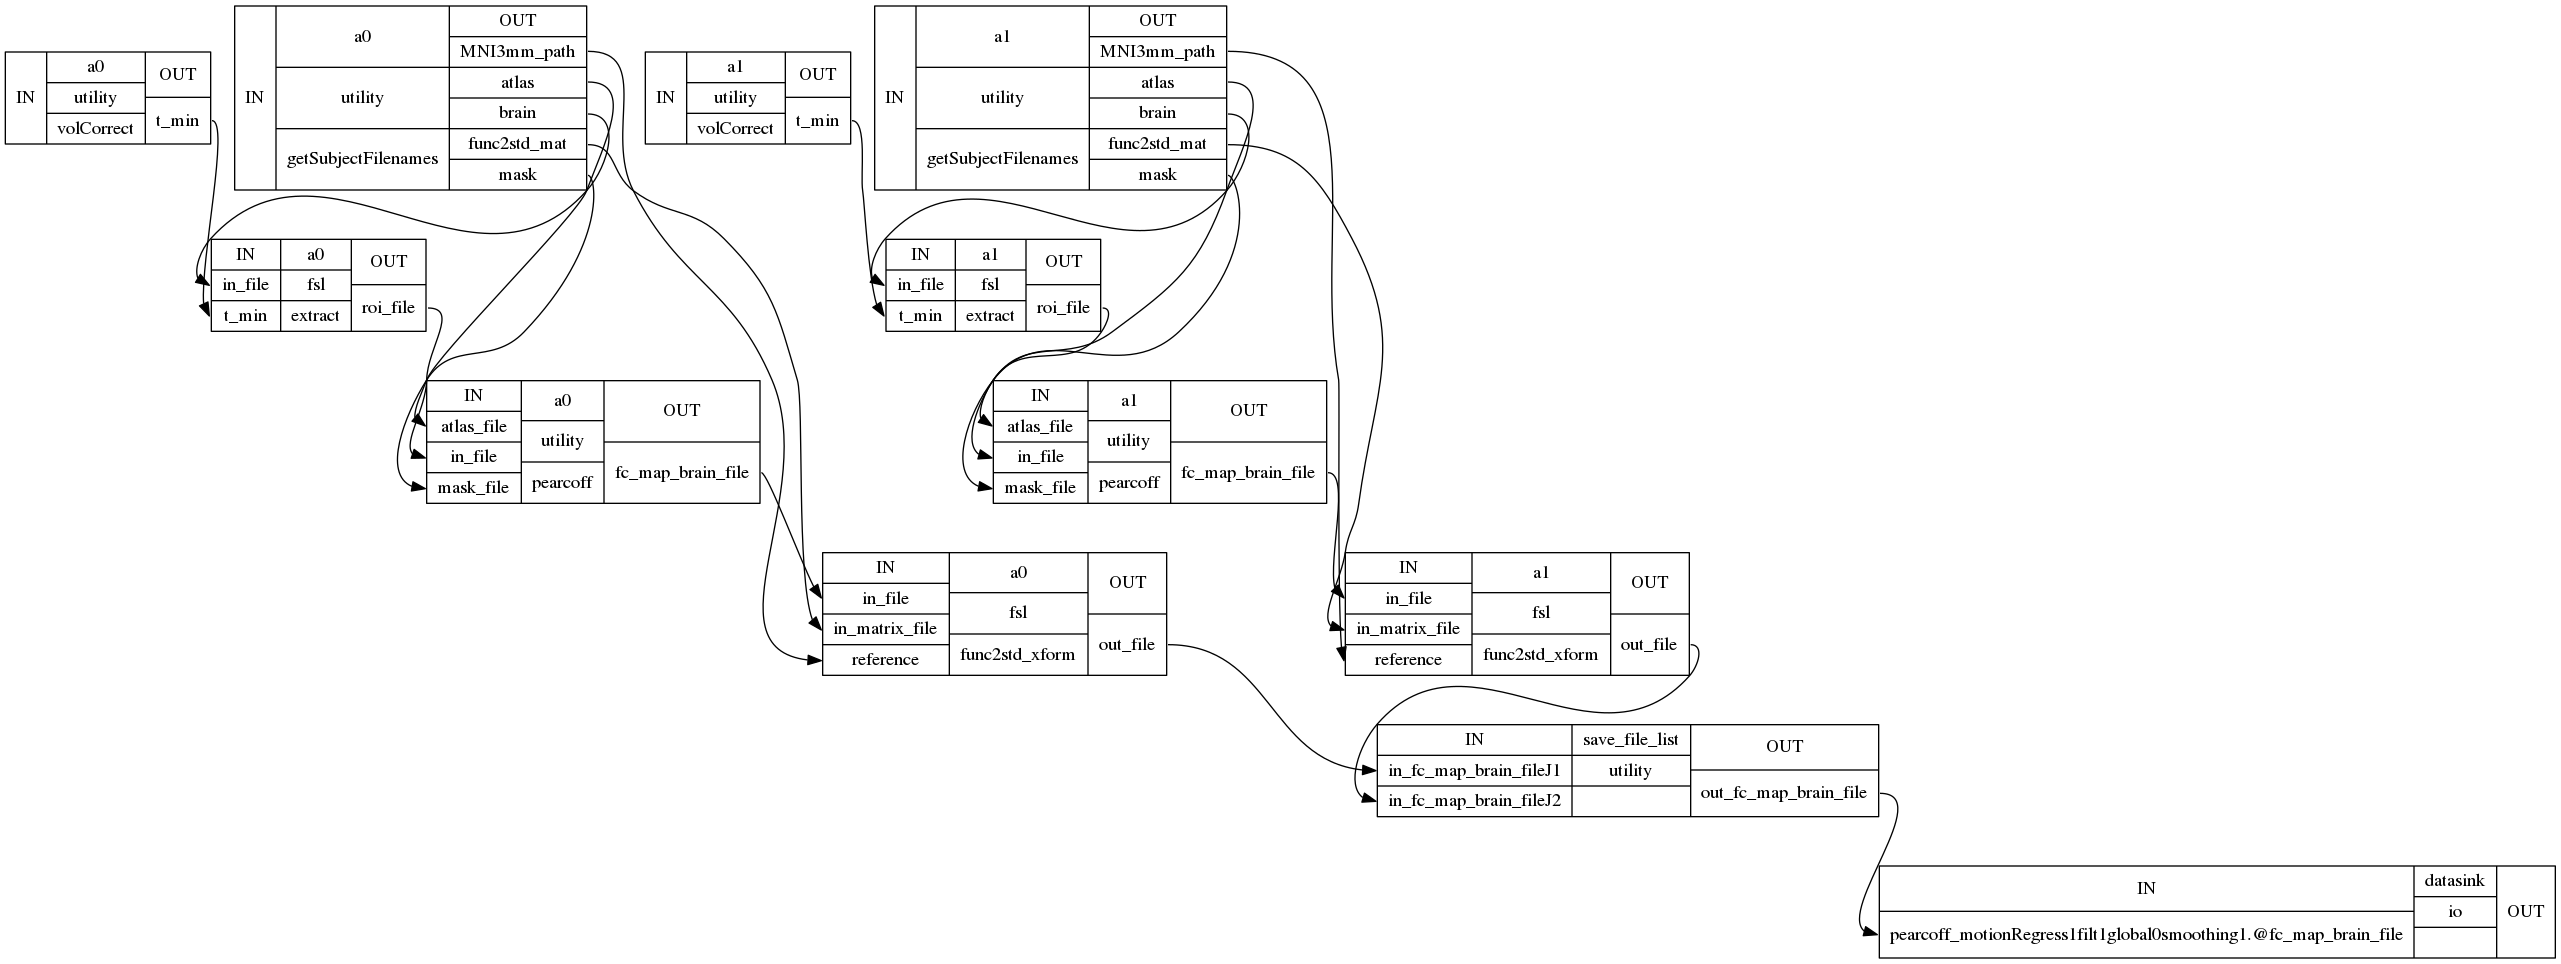

In [1560]:
file_name = opj(base_dir,combination,'graph_detailed.dot.png')
Image(filename=file_name)

In [1561]:
X = np.load("../../results_again_again/temp_dataSink/pearcoff_motionRegress1filt1global0smoothing1/fc_map_brain_file_list.npy")
X

array([ '/home1/varunk/results_again_again/temp_fc/motionRegress1filt1global0smoothing1/_subject_id_51456/func2std_xform/0051456_fc_map_flirt.nii.gz',
       '/home1/varunk/results_again_again/temp_fc/motionRegress1filt1global0smoothing1/_subject_id_51457/func2std_xform/0051457_fc_map_flirt.nii.gz'],
      dtype='<U139')

In [1562]:
!nipypecli show crash-20171228-144509-root-getSubjectFilenames.a1-6a701e42-c600-4b38-b4ba-71c175cbf567.pklz

Usage: nipypecli show [OPTIONS] PKLZ_FILE

Error: Invalid value for "pklz_file": Path "crash-20171228-144509-root-getSubjectFilenames.a1-6a701e42-c600-4b38-b4ba-71c175cbf567.pklz" does not exist.


In [1563]:
import numpy as np
X = np.load('../results_again_again/fc_datasink/pearcoff_motionRegress0filt0global1/fc_map_brain_file_list.npy')
X.shape

FileNotFoundError: [Errno 2] No such file or directory: '../results_again_again/fc_datasink/pearcoff_motionRegress0filt0global1/fc_map_brain_file_list.npy'

In [ ]:
X_temp4 = np.load('/home1/varunk/results_again_again/temp_fc/motionRegress1filt1global0smoothing1/_subject_id_51456/temp4_again.npy')
np.diag(X_temp4)

In [ ]:
X_temp3 = np.load('/home1/varunk/results_again_again/temp_fc/motionRegress1filt1global0smoothing1/_subject_id_51456/temp3.npy')
(X_temp3).shape

In [ ]:
X_temp2 = np.load('/home1/varunk/results_again_again/temp_fc/motionRegress1filt1global0smoothing1/_subject_id_51456/temp2.npy')
(X_temp2).shape

In [ ]:
np.isnan(X_temp3).sum()

In [ ]:
np.isnan(X_temp2).sum()

In [ ]:
X_temp2[254]

In [1566]:
X = np.load('/home1/varunk/results_again_again/temp_fc/motionRegress1filt1global0smoothing1/_subject_id_51456/X.npy')
X[254,:]

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan])

In [132]:
X = np.load('/home1/varunk/results_again_again/fc_datasink_volumes_corrected/pearcoff_motionRegress1filt1global0smoothing1/fc_map_brain_file_list.npy')
X.shape

(1074,)